dataset - данные по продажам игр в зависимости от платформы. 
Цель - провести препроцессинг + сделать описательную статистику данных 

Задачи: 
- Препроцессинг
- Аналитика :
  - показать сколько игр выпускалось в разные годы. Описать и обосновать переломные моменты продаж
  - найти топ 10 платформ с наибольшими суммарными продажами
  - построить распределение по годам в зависимости от сумм продаж
  - выбрать актуальный период начала исследования в зависимости от новой платформы
  - после того, как опередлились с периодом, удалить все данные до начала периода 
  - определить какие платформы лидируют по продажам
- Проверить гипотезу:
  - Средние пользовательские рейтинги платформ Xbox 360 и PS3 одинаковые

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import copy
import seaborn as sns

## Изученные данных из файлов

In [2]:
#Анализ пропусков, дублей, типов

In [3]:
df = pd.read_csv('dataset.csv', on_bad_lines='skip')

In [4]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating;
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E;
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,;
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E;
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E;
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,;


In [5]:
df.shape 

(18017, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18017 entries, 0 to 18016
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             18015 non-null  object 
 1   Platform         18017 non-null  object 
 2   Year_of_Release  17750 non-null  float64
 3   Genre            18015 non-null  object 
 4   NA_sales         18017 non-null  float64
 5   EU_sales         18017 non-null  float64
 6   JP_sales         18017 non-null  float64
 7   Other_sales      18017 non-null  float64
 8   Critic_Score     8180 non-null   float64
 9   User_Score       10051 non-null  object 
 10  Rating;          17995 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [7]:
df.isnull().sum()

Name                  2
Platform              0
Year_of_Release     267
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       9837
User_Score         7966
Rating;              22
dtype: int64

In [8]:
df.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,17750.000000,18017.000000,18017.000000,18017.000000,18017.000000,8180.000000
mean,2006.495324,0.261964,0.147835,0.077619,0.048178,68.912592
std,5.675950,0.838040,0.560561,0.309454,0.215011,14.057749
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.060000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.220000,0.100000,0.030000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [9]:
df.describe(include=['O'])

,Name,Platform,Genre,User_Score,Rating;
count,18015,18017,18015,10051,17995
unique,11481,31,12,96,10
top,Winning Post 7: Maximum 2007,PS2,Sports,tbd,;
freq,1282,3441,3624,2416,8009


In [10]:
df.nunique()

Name               11481
Platform              31
Year_of_Release       37
Genre                 12
NA_sales             402
EU_sales             307
JP_sales             244
Other_sales          155
Critic_Score          82
User_Score            96
Rating;               10
dtype: int64

### Выводы

- В данных много пропусков, ошибок, дублей
- В датасете игры, выпущенные с 1980 по 2016 год
- На первый взгляд, самая популярная платформа PS2 и жанр Sports (будем дальше изучать)

## Предобработка данных

In [11]:
df.groupby('Name').agg({'Platform':'count'}).sort_values('Platform', ascending = False).head()

,Platform
Name,
Winning Post 7: Maximum 2007,1282
Mario Kart 64,25
Superman: The Man of Steel,25
WWF SmackDown! 2: Know Your Role,21
Grand Theft Auto V,21


In [12]:
df = df.drop_duplicates() # дропаем дубли

In [13]:
df = df[df['Name'].notna()] # убираем строки, где нет имени

In [14]:
df = df.rename(columns=str.lower) # названия столбцов к нижнему регистру
df = df.rename(columns={'rating;':'rating'})

Обрабатываем столбцы, где явно допущены ошибки: рейтинг и оценка пользователей

In [15]:
df['rating'] = df['rating'].str.replace(';', '').replace('', np.nan, regex=True) # будет удобнее работать с Nan дальше

In [16]:
df['user_score'] = df['user_score'].str.replace('tbd', '')\
                                .replace('', np.nan, regex=True)\
                                .astype(float)

In [17]:
df.isnull().sum() # перепроверяем что изменилось

name                  0
platform              0
year_of_release     267
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8494
user_score         9039
rating             6688
dtype: int64

In [18]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16336.000000,16603.000000,16603.000000,16603.000000,16603.000000,8109.000000,7564.000000
mean,2006.481697,0.264063,0.145557,0.077850,0.047501,68.978789,7.124564
std,5.886263,0.815947,0.504847,0.309695,0.187314,13.943594,1.501089
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


In [19]:
df.describe(include=['O'])

,name,platform,genre,rating
count,16603,16603,16603,9915
unique,11481,31,12,8
top,Need for Speed: Most Wanted,PS2,Action,E
freq,12,2144,3349,3978


Восстанавливаем год выпуска, где это возможно

In [20]:
for name in df.query('year_of_release.isnull()')['name'].unique():
    index = df.query('name == @name').year_of_release.first_valid_index()
    if index != None:
        year = df.query('name == @name').year_of_release.loc[index]
        temp = df.query('name == @name').year_of_release.fillna(year)
        df.update(temp)    

In [21]:
df = df[df['year_of_release'].notna()] # больше никак не восстановить год выпуска, дропнем пропуски

In [22]:
df.shape

(16457, 11)

### Выводы

- Были восстановлены пропуски в столбце с годом релиза
- В остальных пока оставляем Nan
- Самой популярноой платформой осталась PS2, жанр стал Action

In [23]:
comp_genre=df[['genre','na_sales','eu_sales','jp_sales','other_sales']]
comp_map=comp_genre.groupby('genre').sum()

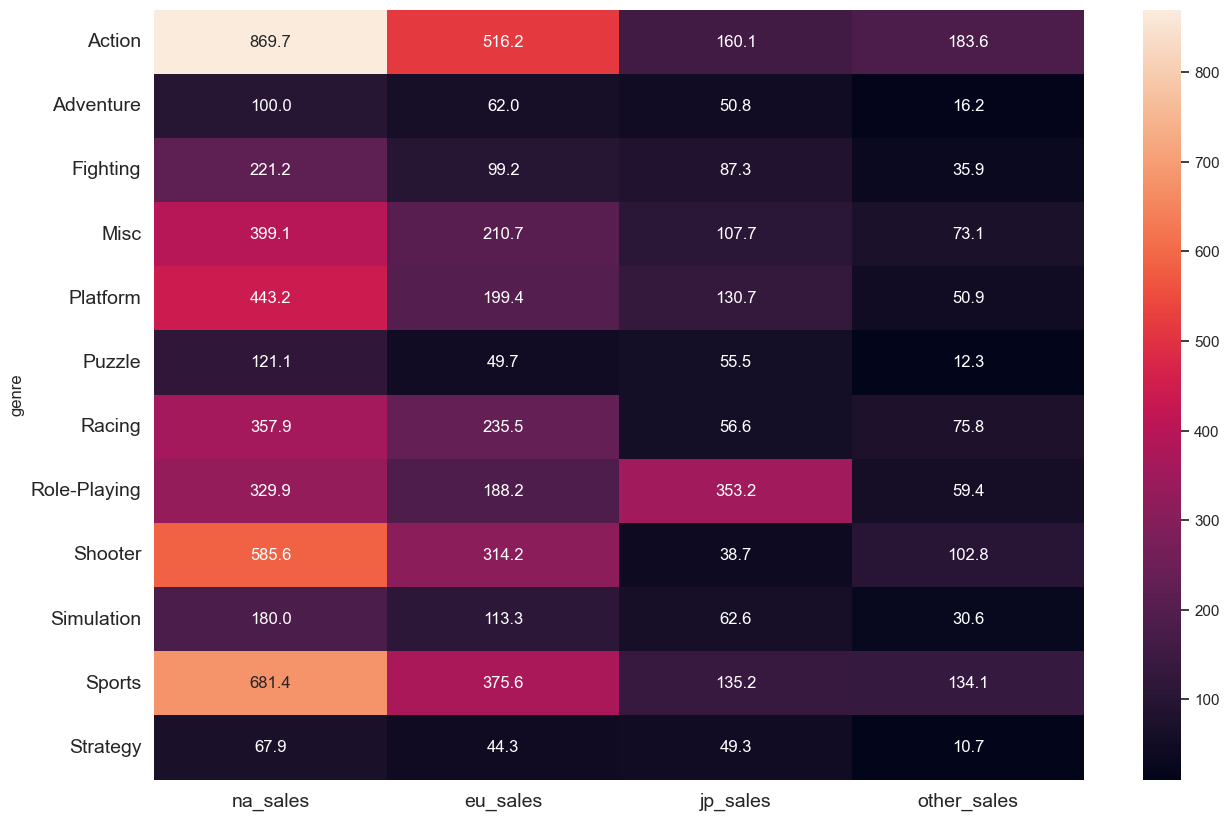

In [24]:
plt.figure(figsize=(15,10))
sns.set(font_scale=1)
sns.heatmap(comp_map,annot=True,fmt='.1f')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Анализ данных

In [25]:
# показать сколько игр выпускалось в разные годы. Описать и обосновать переломные моменты продаж

In [26]:
df['total_sales'] = df.na_sales + df.eu_sales + df.jp_sales + df.other_sales

In [27]:
games_a_year = df.groupby(['year_of_release', 'platform'], as_index = False)\
                .agg({'name':'nunique', 'total_sales':'sum'})

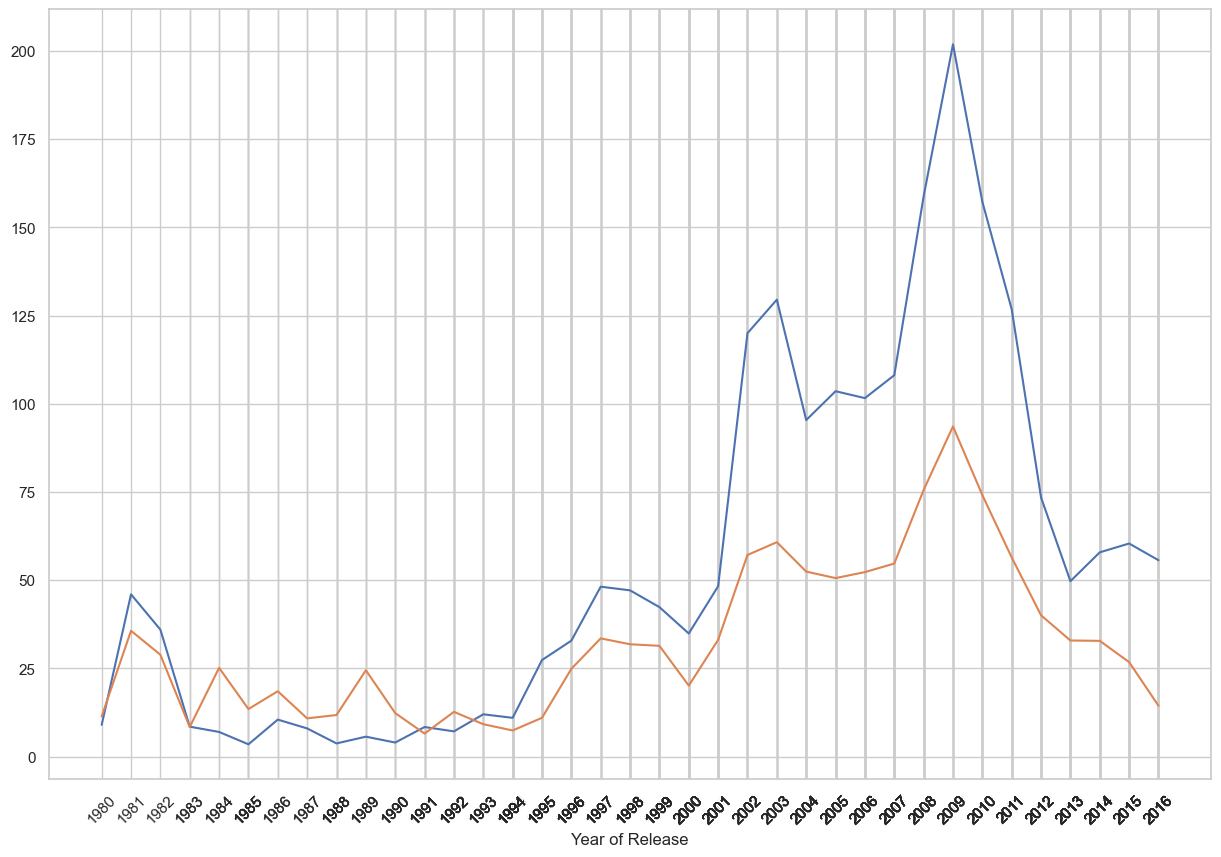

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
sns.lineplot(data = games_a_year, x = 'year_of_release', y = 'name', errorbar=None)
sns.lineplot(data = games_a_year, x = 'year_of_release', y = 'total_sales', errorbar=None)\
        .set(xlabel = 'Year of Release', ylabel='', xticks=games_a_year.year_of_release.values)
plt.xticks(rotation=45)
plt.show()

In [29]:
# найти топ 10 платформ с наибольшими суммарными продажами

In [30]:
platforms = df.groupby('platform', as_index = False)\
                .agg({'total_sales':'sum'})\
                .sort_values('total_sales', ascending = False)\
                .head(10)

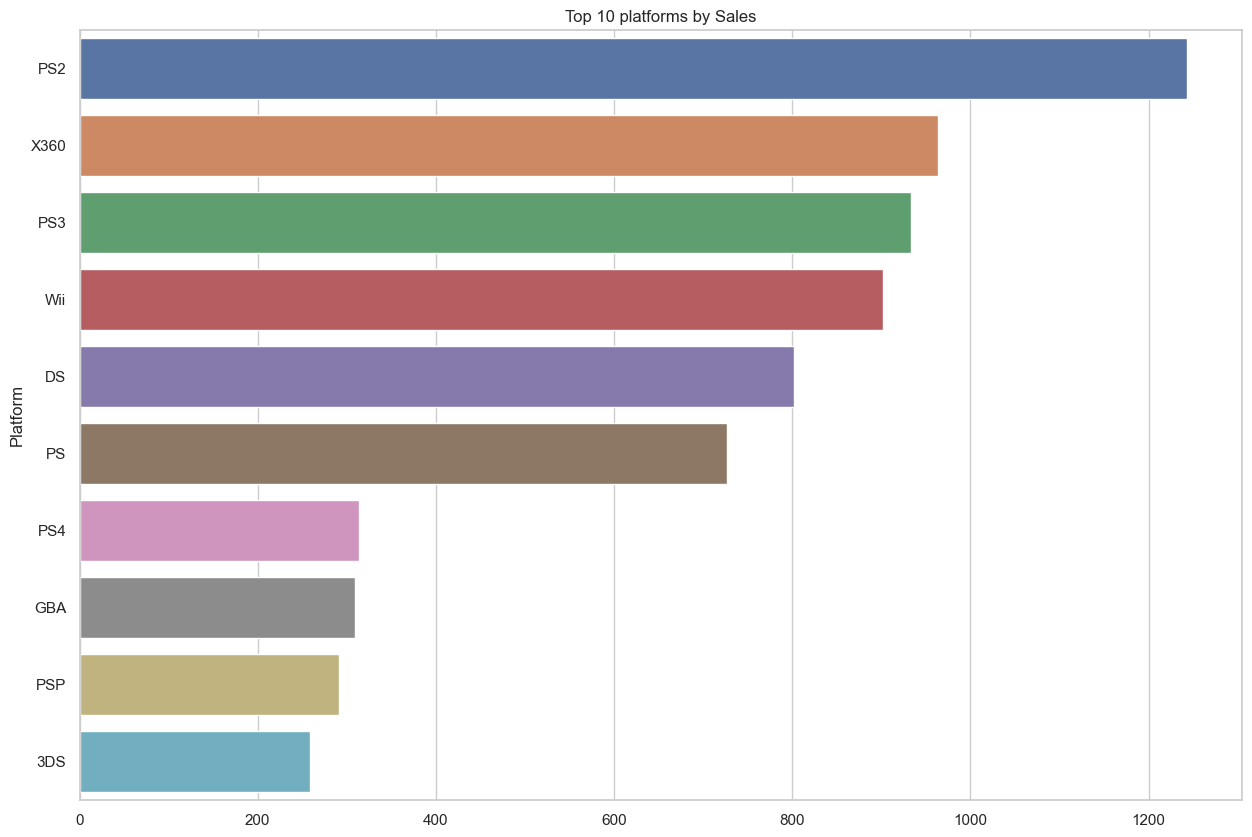

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
sns.barplot(x='total_sales',y='platform',data=platforms)\
.set(title = 'Top 10 platforms by Sales', xlabel='', ylabel='Platform')
plt.show()

In [32]:
# сделать срез от 2009 года и посмотреть какие платформы актуальные( по кол-ву продаж)

In [33]:
df.query('year_of_release == 2009').groupby('platform', as_index = False)\
                .agg({'total_sales':'sum'})\
                .sort_values('total_sales', ascending = False)

,platform,total_sales
5,Wii,206.31
3,PS3,130.23
6,X360,120.03
0,DS,118.93
4,PSP,37.18
2,PS2,25.84
1,PC,16.51


In [34]:
# выбрать актуальный период начала исследования в зависимости от новой платформы

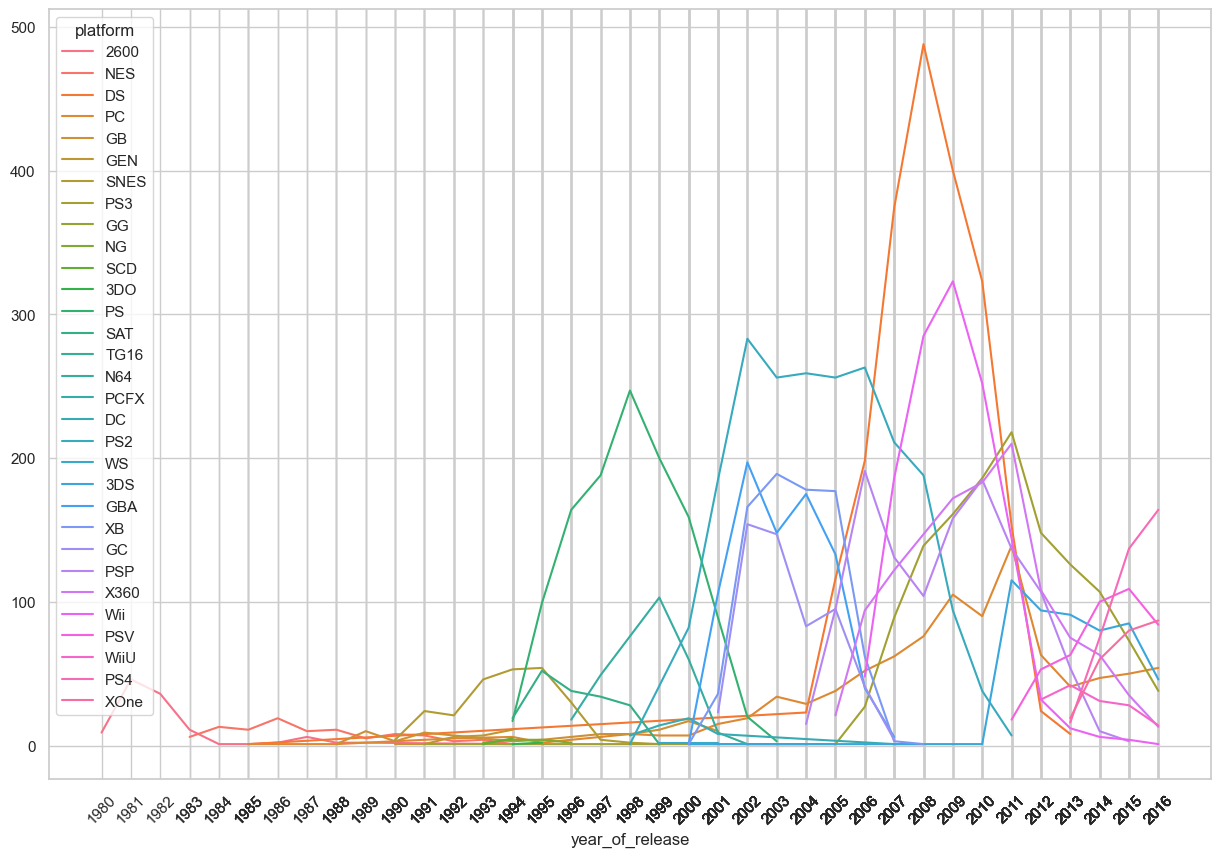

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,10))
sns.lineplot(data = games_a_year, x = 'year_of_release', y = 'name', hue = 'platform')\
        .set(ylabel='', xticks=games_a_year.year_of_release.values)
plt.xticks(rotation=45)
plt.show()

In [36]:
# После того, как опередлились с периодом, удалить все данные до начала периода 
df = df.query('year_of_release >= 1994') # как новая платформа была выбрана PS

In [37]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80


In [38]:
df.groupby('platform', as_index = False)\
                .agg({'total_sales':'sum'})\
                .sort_values('total_sales', ascending = False)\
                .head(10)

,platform,total_sales
15,PS2,1242.72
27,X360,963.73
16,PS3,932.66
25,Wii,901.37
4,DS,802.05
14,PS,726.56
17,PS4,314.14
6,GBA,309.18
18,PSP,291.44
2,3DS,258.45


### Вывод 
Проведя анализ данных мы заметили такие закономерности как:
- Бум продаж случился в 2009 году, мб связано с кризисом 2008 года и массовыми сокращениями, люди сидели дома и игры были доступным досугом
- Начиная с 1994 года наблюдался рост продаж игр, вероятно связано с выходом PS
- Самая популярная платформа PS2 по продажам

## Проверка гипотезы

H0 - средние наших выборок не отличаются
H1 - средние наших выборок отличаются


Критический уровень значимости зададим 0.05 

In [42]:
statistics = df.groupby('platform', as_index = False)\
                .agg({'user_score':['count','mean', 'std', 'var']})

In [43]:
statistics.dropna()

platform user_score                              
                 count      mean       std       var
2       3DS        172  6.850000  1.418405  2.011871
3        DC         14  8.528571  0.916875  0.840659
4        DS        511  7.020939  1.512617  2.288012
6       GBA        251  7.669323  1.440269  2.074375
7        GC        363  7.610468  1.367480  1.870001
12       PC        759  7.068906  1.521563  2.315153
14       PS        158  7.864557  1.343258  1.804341
15      PS2       1225  7.630122  1.304435  1.701551
16      PS3        868  6.722120  1.461791  2.136834
17      PS4        257  6.748249  1.459481  2.130085
18      PSP        420  7.227381  1.228301  1.508723
19      PSV        142  7.334507  1.380104  1.904687
25      Wii        554  6.731408  1.743193  3.038722
26     WiiU        100  6.904000  1.435405  2.060388
27     X360        956  6.682427  1.440922  2.076256
28       XB        579  7.513472  1.487767  2.213451
29     XOne        181  6.527072  1.382665  1.911763

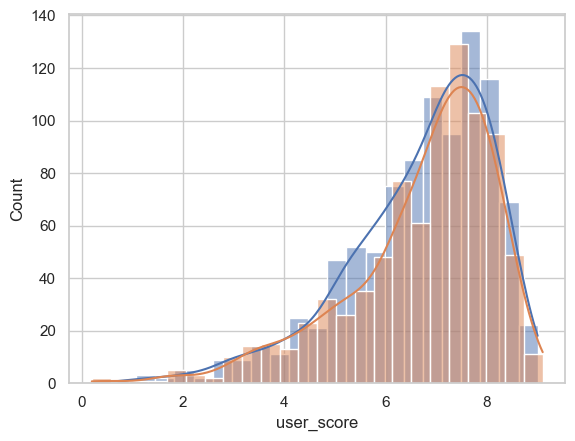

In [56]:
sns.histplot(data = df.query('platform == "X360"'), x = 'user_score', kde = True)
sns.histplot(data = df.query('platform == "PS3"'), x = 'user_score', kde = True)
plt.show()

Не будем полагаться только на график, проверим распределения на нормальность:

In [51]:
X360 = df.query('platform == "X360"').user_score.dropna()
PS3 = df.query('platform == "PS3"').user_score.dropna()

In [52]:
st.normaltest(X360)

NormaltestResult(statistic=149.2319151910935, pvalue=3.932795409902719e-33)

In [53]:
st.normaltest(PS3)

NormaltestResult(statistic=170.85955653825806, pvalue=7.912590813663693e-38)

Значение p-value намного меньше заданного критического значения, значит выборочные значения не принадлежат нормальному закону.
Теперь мы точно знаем, что распеределения не являются нормальными.   
А значит, учитывая таже, что переменная количественная, используем u-критерий Манна-Уитни

In [54]:
st.mannwhitneyu(PS3, X360, alternative='two-sided')

MannwhitneyuResult(statistic=424846.0, pvalue=0.37601205411656247)

p-value значительно больше 0.05, не можем отвергнуть нулевую гипотезу

Датасет не дал нам ответа какая же платформа всё-таки лучше по мнению пользователей.

## Вывод проекта

В ходе выполнения исследования мы подготовили данные и нашли и исправили ошибки в данных, где было возможно заполнили пропуски, выявили самую популярную платформу (PS2) и самый популярный жанр(Action). Узнали, что пользователи ПК в среднем ставят более высокие оценки, что возможно экономический кризис хорошо влияет на продажи игр.